# spiketorch Demo

In which we test some basic functionality in the [__spiketorch__](https://github.com/djsaunde/spiketorch) spiking neural networks (SNNs) Python library.

__Author__: [Dan Saunders](https://djsaunde.github.io)

## Background

The __spiketorch__ library allows one to simulate simple SNNs while making use of the powerful and flexible `torch.Tensor` object, and run on compatible GPU hardware (pending some recently introduced backwards-compatibility breaking bugs) for considerable speedups on large networks. It is meant to be used in the development of machine learning algorithms in the [Biologically Inspired Neural and Dynamical Systems lab](http://binds.cs.umass.edu/), supported by [DARPA](https://www.darpa.mil/) grant number DARPA-HR0011-16-l-0006, under the project titled *Superior Artificial Intelligence (AI)*.

__spiketorch__ currently supports the simulation of `Network`s of [leaky integrate-and-fire (LIF) neurons](http://icwww.epfl.ch/~gerstner/SPNM/node26.html) in groups of one or more (by objects `LIFGroup` and modification `AdaptiveLIFGroup`). To simulate such simple models, we only need to track neuron membrane potential, or voltage (recorded by vectors $\mathbf{v}$), and the occurrence and mechanism of [action potential](https://en.wikipedia.org/wiki/Action_potential) generation, or spiking (recorded by vectors $\mathbf{s}$).

__Note__: The `AdaptiveLIFGroup` has another state variable, $\theta$, which represents an adaptive neuron membrane potential, updated each time the neuron fires, but this modification isn't typical of the LIF neuron model. It was introduced in a [previous paper](https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full#) as a mechanism of *homeostasis*; that is, ensuring that all neurons have appromixately the same firing rate.

Neuron voltage dynamics $\mathbf{v}$ are defined to exponentially decay towards a value $v_{\textrm{rest}}$ in the absence of input. The `InputGroup` class of neurons do not have internal dynamics; rather, their input are fixed by the user. 

We say that a neuron *spikes* or *fires* when its membrane potential $v$ crosses a critical value, $\mathcal{v}$, the *threshold potential*. We record this as a entry of $1$ in the corresponding entry of spike vector $\mathbf{s}$ and reset the membrane potential to a *reset potential* $v_{\textrm{reset}}$, and these spikes may be used in downstream processing, if the neurons that emitted them are connected to other neurons.

Connections between neurons are handled via the `Synapse` and `STDPSynapse` objects. In both cases, one must specify the `source` and `target` groups of neurons, and optionally a connection matrix `w`; otherwise, a weight matrix of values with entries sampled from $\textrm{Uniform(0, 1)}$ is used. In the case of `STDPSynapse`s, other parameters governing pre- and post-synaptic learning rates, maximal weight values, and weight normalization can be specified, and weights are adapted via a simple [online STDP learning rule](http://www.scholarpedia.org/article/Spike-timing_dependent_plasticity).

As may be intuited, SNN simulations necessarily take place *in time*. The programmer can specify network initial conditions, parameters, and inputs over a simulation episode, and then call the `Network.run(mode, input, time)` function to simulate the SNN for `time` steps. If `mode='train'`, `STDPSynapse` weights and `AdaptiveLIFGroup` $\theta$ parameters are adapted at every simulation step; otherwise (`mode='test'`), they are held fixed, possibly loaded from disk at the start of a testing phase. At the end of a `Network.run()` call, a dictionary of spike times per neuron population is returned, useful for visualization or network activity-dependent control in other parts of the program.

## Imports and setup

In [1]:
from spiketorch.network import Network
from spiketorch.groups import *
from spiketorch.synapses import *

import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Building a simple network

Let's create a network composed of randomly spiking input neurons connected to a group of otherwise unconnected neurons, and record their spiking activity. Connection weights from input to non-input neurons are samples from the unit Gaussian, $\mathcal{N}(0, 1)$.

We'll run the SNN simulation for 500 timesteps (corresponding to about 1ms), with 100 input and 100 excitatory neurons, respectively. Each input neuron will fire with probability $\frac{1}{20}$ at each timestep, corresponding to a frequency of $\approx \frac{1000\textrm{ms}}{20} = 50\textrm{Hz}$.

In [2]:
timesteps = 500
n_inpt = 100
n_excitatory = 100

p_fire = 0.05

In [3]:
network = Network()

# Neuron groups.
network.add_group(InputGroup(n_inpt), 'input')
network.add_group(LIFGroup(n_excitatory), 'population')

# Synaptic connections.
w = torch.randn(n_inpt, n_excitatory)
network.add_synapses(Synapses(network.groups['input'], network.groups['population'],
                                                w=w), name=('input', 'population'))

# Create random inputs for `timesteps`.
inpt = np.random.binomial(2, p_fire, size=[timesteps, n_inpt])
inpt = torch.from_numpy(inpt)
inpts = {'input' : inpt}

# Run the network for `timesteps`.
output = network.run(mode='static', inpts=inpts, time=timesteps)

Plotting the input and non-input spiking activity, we notice that each input neuron indeeds spikes approximately 1 out of every 20 timesteps. Neurons in the non-input population are driven according to the input; however, since the connectivity is random uniform, it is difficult to guess which input neurons are driving which non-input neurons to fire.

Given the relative infrequency of spiking of the non-input population to the input population, it's clear that several spikes impinging on a neuron in a short time window are required to generate a spike. [This is an important feature of biological neurons](http://neuronaldynamics.epfl.ch/online/Ch1.S2.html)!

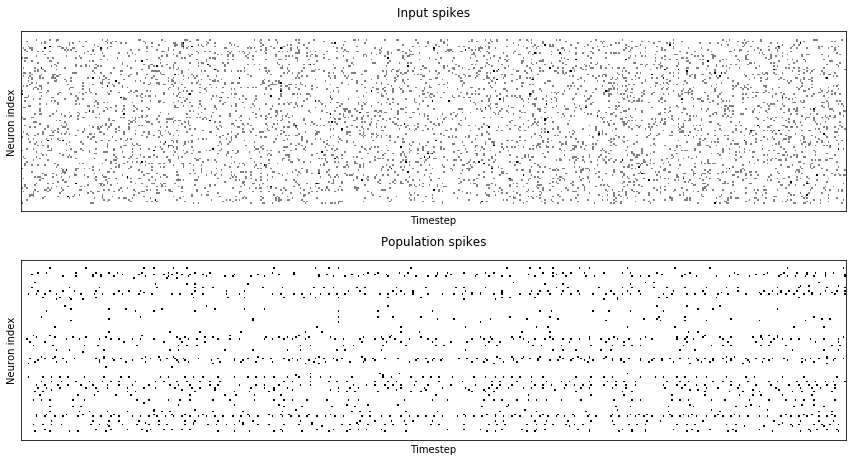

In [4]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(12, 6.5))

ax1.matshow(output['input'].numpy().T, cmap='binary')
ax2.matshow(output['population'].numpy().T, cmap='binary')

ax1.set_xticks(()); ax1.set_yticks(())
ax2.set_xticks(()); ax2.set_yticks(())
ax1.set_title('Input spikes'); ax2.set_title('Population spikes')
ax1.set_ylabel('Neuron index'); ax2.set_ylabel('Neuron index')
ax1.set_xlabel('Timestep'); ax2.set_xlabel('Timestep')

plt.tight_layout(); plt.show()

Let's add some connectivity in the non-input population of neurons. Namely, we'll connect each neuron to all other neurons with a synapse weight sampled from the unit Gaussian, $\mathcal{N} (0, 1)$.

In [5]:
network = Network()

# Neuron groups.
network.add_group(InputGroup(n_inpt), 'input')
network.add_group(LIFGroup(n_excitatory), 'population')

# Synaptic connections.
w = torch.randn(n_inpt, n_excitatory)
network.add_synapses(Synapses(network.groups['input'], network.groups['population'],
                                                w=w), name=('input', 'population'))

w = torch.randn(n_excitatory, n_excitatory)
network.add_synapses(Synapses(network.groups['population'], network.groups['population'],
                                                w=w), name=('population', 'population'))

# Create random inputs for `timesteps`.
inpt = np.random.binomial(2, p_fire, size=[timesteps, n_inpt])
inpt = torch.from_numpy(inpt)
inpts = {'input' : inpt}

# Run the network for `timesteps`.
output = network.run(mode='static', inpts=inpts, time=timesteps)

Interestingly, adding this recurrent connectivity doesn't appear to qualitatively change the non-input population spiking behavior much.

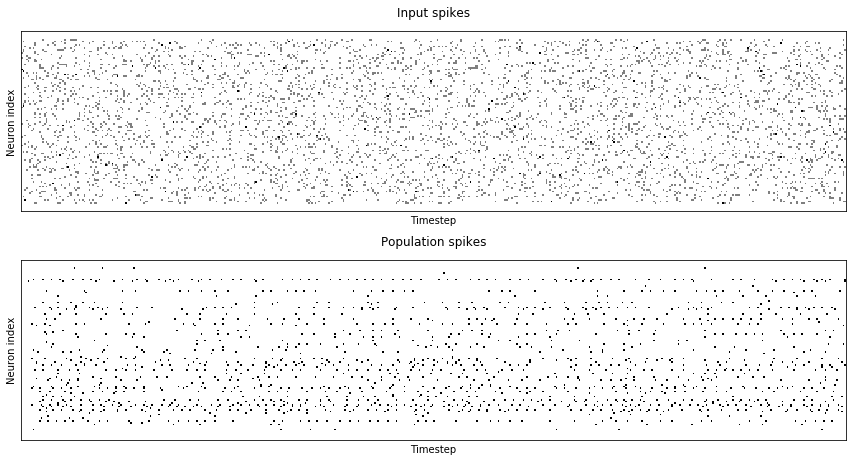

In [6]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(12, 6.5))

ax1.matshow(output['input'].numpy().T, cmap='binary')
ax2.matshow(output['population'].numpy().T, cmap='binary')

ax1.set_xticks(()); ax1.set_yticks(())
ax2.set_xticks(()); ax2.set_yticks(())
ax1.set_title('Input spikes'); ax2.set_title('Population spikes')
ax1.set_ylabel('Neuron index'); ax2.set_ylabel('Neuron index')
ax1.set_xlabel('Timestep'); ax2.set_xlabel('Timestep')

plt.tight_layout(); plt.show()

Let's try some more interesting structure. Instead of random connectivity in the non-input population, why not have neurons inhibit each other more with increasing inter-neuron distance?

In [7]:
inhib = 2.5  # Controls strength of inter-neuron inhibition

network = Network()

# Neuron groups.
network.add_group(InputGroup(n_inpt), 'input')
network.add_group(LIFGroup(n_excitatory), 'population')

# Synaptic connections.
w = torch.randn(n_inpt, n_excitatory)
network.add_synapses(Synapses(network.groups['input'], network.groups['population'],
                                                w=w), name=('input', 'population'))
w = -np.array([[inhib * np.sqrt(np.linalg.norm(idx1 - idx2)) for idx2 in \
            range(n_excitatory)] for idx1 in range(n_excitatory)])
w = torch.from_numpy(w).float()
network.add_synapses(Synapses(network.groups['population'], network.groups['population'],
                                                w=w), name=('population', 'population'))

# Create random inputs for `timesteps`.
inpt = np.random.binomial(2, p_fire, size=[timesteps, n_inpt])
inpt = torch.from_numpy(inpt)
inpts = {'input' : inpt}

# Run the network for `timesteps`.
output = network.run(mode='static', inpts=inpts, time=timesteps)

Due to increasing inhibition with inter-neuron distance, after an initial transient, most spiking activity in the non-input population is localized in a small neighborhood of neurons. The constant `inhib` in the above code block controls this effect; try changing it to see what happens.

In the limit of `inhib = 0`, we recover the first SNN model from above. As `inhib` increases, eventually we arrive to a point where only one neuron can fire at a time; this neuron has precluded all other neurons from firing by inhibiting it greatly.

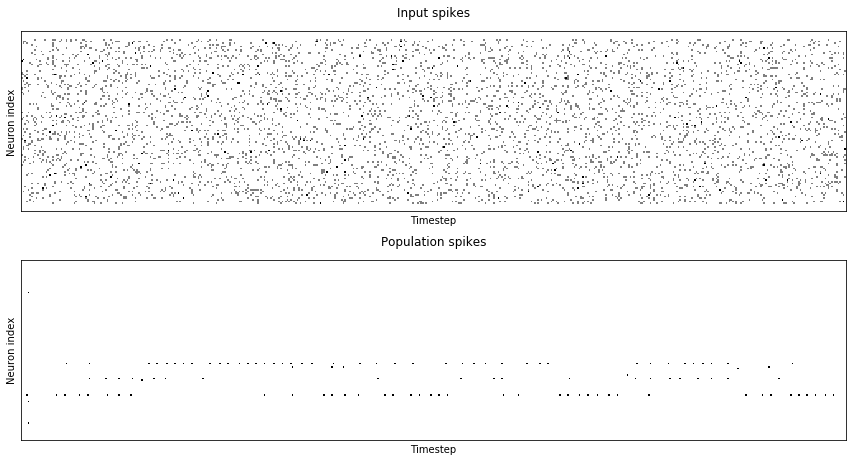

In [8]:
fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True, figsize=(12, 6.5))

ax1.matshow(output['input'].numpy().T, cmap='binary')
ax2.matshow(output['population'].numpy().T, cmap='binary')

ax1.set_xticks(()); ax1.set_yticks(())
ax2.set_xticks(()); ax2.set_yticks(())
ax1.set_title('Input spikes'); ax2.set_title('Population spikes')
ax1.set_ylabel('Neuron index'); ax2.set_ylabel('Neuron index')
ax1.set_xlabel('Timestep'); ax2.set_xlabel('Timestep')

plt.tight_layout(); plt.show()

Take a look at the weights: along the main diagonal, no neuron inhibits itself. On the other hand, distal neurons are inhibited more as inter-neuron distance increases.

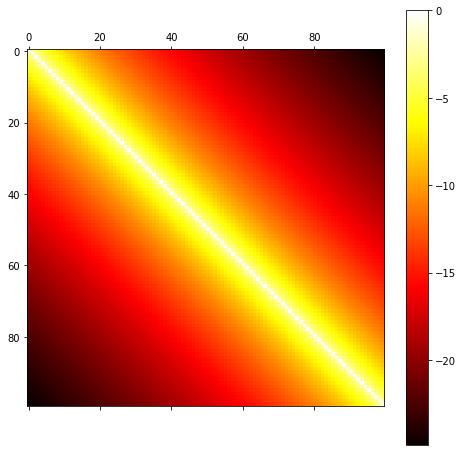

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.matshow(w.numpy(), cmap='hot')
plt.colorbar(im); plt.show()